# Essential Libraries

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
from csv import reader
from optparse import OptionParser
import pandas as pd
from collections import defaultdict
from itertools import chain, combinations
from sklearn.model_selection import KFold
import csv, itertools

In [4]:
def dataFromFile(fname, splitter, front_lim = 0, end_lim = 0):
    """Function which reads from the file and yields a generator"""
    itemSets = []
    #itemSet = set()
    # Open text file
    with open(fname, "r") as file_iter:
        for line in file_iter:
            # Remove trailing commas, spaces, and all other required characters.
            line = line.strip()[front_lim:(-end_lim)]#.rstrip(end_strip).strip() removed it as it removes 
            #all eligible characters passed to end_strip argument.
            record = set([int(ele) for ele in line.split(splitter)])
            #for item in record:
            #    itemSet.add(frozenset([item]))
            itemSets.append(record)
    return itemSets

In [5]:
# Import the data...
data = dataFromFile("BMSWebView2.txt", " -1 ", front_lim = 0, end_lim = 6)

## Basic Apriori...

In [6]:
class Apriori:
    """Apriori Class that operates on sequence of transactions 
    that are expected to be cleaned (should be in list format)"""
    def __init__(self, minSup, output_dict_col_names, probs_true = False):
        self.minSup = minSup
        self.output_dict_col_names = output_dict_col_names
        self.probs_true = probs_true
        
    def _powerset(self, s):
        """Construct all possible subsets from a given set."""
        return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))


    def _getAboveMinSup(self, itemSet, TransactionList):
        """Return Frequent ItemSet and A dictionary with their Support."""
        freqItemSet = set()
        localItemSetWithSup = defaultdict(int)
        freqItemSetWithSup = dict()
        # For Each candidate in CandidateSet, scanning the whole Database to get it's count.
        for item in itemSet:
            for transaction in TransactionList:
                if item.issubset(transaction):
                    #globalItemSetWithSup[item] += 1
                    localItemSetWithSup[item] += 1
        # Define a variable for TransactionList length.
        trans_len = len(TransactionList)
        for item, supCount in localItemSetWithSup.items():
            support = float(supCount / trans_len)
            if(support >= self.minSup):
                freqItemSet.add(item)
        if self.probs_true:
            for uniq_item in freqItemSet:
                freqItemSetWithSup[uniq_item] = localItemSetWithSup[uniq_item]/trans_len
        else:
            for uniq_item in freqItemSet:
                freqItemSetWithSup[uniq_item] = localItemSetWithSup[uniq_item]

        return freqItemSet, freqItemSetWithSup


    def _getUnion(self, itemSet, length):
        """Generating next-Level candidateSet from the current Frequent ItemSet."""
        return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])


    def _pruning(self, candidateSet, prevFreqSet, length):
        """Applying the 'Anti-Monotonicity' rule to remove 
        those candidates whose subsets are not frequent."""
        tempCandidateSet = candidateSet.copy()
        for item in candidateSet:
            subsets = combinations(item, length)
            for subset in subsets:
                # if the subset is not in previous K-frequent get, then remove the set
                if(frozenset(subset) not in prevFreqSet):
                    tempCandidateSet.remove(item)
                    break
        return tempCandidateSet


    #def associationRule(freqItemSet, itemSetWithSup, minConf):
    #    rules = []
    #    for k, itemSet in freqItemSet.items():
    #        for item in itemSet:
    #            subsets = powerset(item)
    #            for s in subsets:
    #                confidence = float(
    #                    itemSetWithSup[item] / itemSetWithSup[frozenset(s)])
    #                if(confidence > minConf):
    #                    rules.append([set(s), set(item.difference(s)), confidence])
    #    return rules


    def _getItemSetFromList(self, TransactionList):
        """Generating Level-1 candidates"""
        tempItemSet = set()

        for itemSet in TransactionList:
            for item in itemSet:
                tempItemSet.add(frozenset([item]))

        return tempItemSet


    def _dict_to_dataframe(self, dict_):
        """Convert nested dictionaries to dataframes"""
        df = pd.DataFrame(columns = self.output_dict_col_names)
        for _, vals in dict_.items():
            req_dict = {self.output_dict_col_names[0]: [key for key in vals.keys()],\
                        self.output_dict_col_names[1]: [vals[key] for key in vals.keys()]}
            df = df.append(pd.DataFrame.from_dict(req_dict))
        return df
    
    def fit(self, TransactionList):
        """The Driver function that returns the frequent itemset with their support count."""
        # Get C-1 iemSet List
        C1ItemSet = self._getItemSetFromList(TransactionList)
        # Final result global frequent itemset
        globalFreqItemSetWithSup = dict()
        # Storing global itemset with support count --> needed for Confidence count.
        #globalItemSetWithSup = defaultdict(int)
        # Obtain Level-1 Frequent itemSetList and their support counts
        L1ItemSet, L1ItemSetWithSup = self._getAboveMinSup(C1ItemSet, TransactionList)
        currentLSet = L1ItemSet
        currentLSetWithSup = L1ItemSetWithSup
        k = 2

        # Calculating frequent item set
        while(currentLSet):
            # Storing frequent itemset
            globalFreqItemSetWithSup[k-1] = currentLSetWithSup
            # Self-joining Lk
            candidateSet = self._getUnion(currentLSet, k)
            # Perform subset testing and remove pruned supersets
            candidateSet = self._pruning(candidateSet, currentLSet, k-1)
            # Scanning itemSet for counting support
            currentLSet, currentLSetWithSup = self._getAboveMinSup(candidateSet, TransactionList)
            k += 1

        #rules = associationRule(globalFreqItemSet, globalItemSetWithSup, minConf)
        #rules.sort(key=lambda x: x[2])
        return self._dict_to_dataframe(globalFreqItemSetWithSup)#, rules

In [33]:
minSup = 5*100/77512

apriori = Apriori(minSup, ["itemsets", "support"], probs_true = False)
globalFreqItemSetDict = apriori.fit(data)

print("Global Frequent ItemSet = \n")
globalFreqItemSetDict.style

In [37]:
(globalFreqItemSetDict).sort_values(by='support', ascending=False)

,itemsets,support
19,(55267),3766
57,(55323),3417
97,(55319),2497
66,(55271),2284
9,(55351),2249
...,...,...
18,(55623),505
58,"(55339, 55315)",503
28,"(55323, 55315, 55271)",502
4,"(55267, 55319, 55323, 55295)",502


In [5]:
def closed_max_sets(frequent_itemset_dict, output_type = "closed", show_time = True):
    """Requires Dictionary of Frequent ItemSet where Columns should be 'itemset' and their 'support'.
    output_type: closed or max
    """
    # Find closed/max frequent itemset using frequent itemset found in task1
    su = frequent_itemset_dict.support.unique()#all unique support count
    # for Closed...
    if output_type == "closed":
        #Dictionay storing itemset with same support count key
        fredic = {}
        # Clubbing all those frequent itemsets whose support count are same 
        # with support count as key in a dictionary.--> for CLOSED sets.
        for i in range(len(su)):
            inset = list(frequent_itemset_dict.loc[frequent_itemset_dict.support ==su[i]]['itemsets'])
            fredic[su[i]] = inset
        #Find Closed frequent itemset
        start_time = time.time()
        cl = defaultdict(list)
        for index, row in frequent_itemset_dict.iterrows():
            isclose = True
            concerned_itemset = row['itemsets']
            concerned_itemset_sup = row['support']
            # Taking the collection of itemsets whose counts are less than 'concerned_itemset_sup'
            checkset = fredic[concerned_itemset_sup]
            for i in checkset:
                if (concerned_itemset != i):
                    # Main check is here where we're seeing if a potential closed frequent 
                    # set is subset of other with same count.
                    if(frozenset.issubset(concerned_itemset, i)):
                        isclose = False
                        break
            # Append the Closed set.
            if(isclose):
                cl["itemset"].append(concerned_itemset)
                cl["support"].append(concerned_itemset_sup)
        if show_time:
            print('Time to find Close frequent itemset')
            print("--- %s seconds ---" % (time.time() - start_time))
        return pd.DataFrame.from_dict(cl)
    else:
        # Clubbing all those frequent itemsets whose support count are less than a particular count
        # which is set as a key in a dictionary.--> For MaxiMAL Sets.
        fredic2 = {}
        for i in range(len(su)):
            inset2 = list(frequent_itemset_dict.loc[frequent_itemset_dict.support<=su[i]]['itemsets'])
            fredic2[su[i]] = inset2
        #Find Max frequent itemset
        start_time = time.time()
        ml = defaultdict(list)
        for index, row in frequent.iterrows():
            isMax = True
            concerned_itemset = row['itemsets']
            concerned_itemset_sup = row['support']
            # Taking the collection of itemsets whose counts are less than 'concerned_itemset_sup'
            checkset = fredic2[concerned_itemset_sup]
            for i in checkset:
                if (concerned_itemset != i):
                    # Main check is here where we're seeing if a potential max frequent 
                    # set is subset of other frequent set.
                    if(frozenset.issubset(concerned_itemset, i)):
                        # since <= operation is there, more chance of getting Flase Flag, hence chance to get
                        # Max set is lower than Closed and hence Max is Subset of Closed.
                        isMax = False
                        break
            # Append the Maximal set.
            if(isMax):
                ml["itemset"].append(concerned_itemset)
                ml["support"].append(concerned_itemset_sup)
        if show_time:
            print('Time to find Max frequent itemset')
            print("--- %s seconds ---" % (time.time() - start_time))
        return pd.DataFrame.from_dict(ml)

In [27]:
cl = closed_max_sets(globalFreqItemSetDict)
print("Closed Frequent ItemSets are:\n")
cl

Time to find Close frequent itemset
--- 0.022665977478027344 seconds ---
Closed Frequent ItemSets are:



,itemset,support
0,(56765),950
1,(89721),940
2,(250539),791
3,(55283),2093
4,(89813),573
...,...,...
215,"(55295, 55315, 55267, 55319)",500
216,"(55295, 55323, 55267, 55319)",502
217,"(55323, 55315, 55319, 55351)",547
218,"(55323, 55315, 55267, 55319)",605


## Partition Algo on Apriori...

In [11]:
class Partition:
    """
    Run Partition-Apriori on the Whole dataset.
    partitioned_data: A dict containing required partitioned_data (2D array of Lists) with key = partition no.
    support: list of true numbers support, e.g. support_lst = [--some_%--*len(part) for each part]
    globalSup = some_%*len(data) = sum(support)
    size_of_transaction: size of dataset = no. of transactions
    """
    def __init__(self, support, globalSup, size_of_transaction, time_calc = False):
        """Set the attributes to constructor"""
        self.support = support
        self.globalSup = globalSup
        self.size_of_transaction = size_of_transaction
        self.time_calc = time_calc
        
    def split(self, X, n_splits, random_state):
        """make partition of data."""
        # Construct an empty dictionary for partitioned_data.
        partitioned_data = dict(); k = 1
        # construct a splitter.
        kf = KFold(n_splits = n_splits, random_state = random_state, shuffle = True)
        for _, test_index in kf.split(X):
            #print("TRAIN:", train_index, "TEST:", test_index)
            partitioned_data[k] = [X[_index] for _index in test_index]
            k += 1
        return partitioned_data

    def _partition_len_list(self, partitioned_data):
        """return length of each partition"""
        return [len(val) for val in partitioned_data.values()]
    
    def _firstScan(self, partitioned_data):
        """ First Scan -- within each partition to generate all frequent itemsets"""
        # Create an empty dictionary to store dataframe...
        distinct = dict()
        # Apply basic Apriori to each partition.
        if self.time_calc:
            time_list = []
            for key, val in partitioned_data.items():
                # Start timer
                start = timeit.default_timer()
                # create an instance of Apriori...
                apriori = Apriori(self.support[key-1]/len(val), ["itemsets", "support"], probs_true = False)
                distinct[key] = apriori.fit(val)
                # STop timer
                stop = timeit.default_timer()
                time_list.append(stop - start)
            return distinct, time_list
        else:
            for key, val in partitioned_data.items():
                apriori = Apriori(self.support[key-1]/len(val), ["itemsets", "support"], probs_true = False)
                distinct[key] = apriori.fit(val)
            return distinct
    
    def _frequentItemSetFromPartitions(self, distinct):
        """return the L1ItemSet by taking union of all L1 Item Set from each partition"""
        # Filter out all frequent itemsets from each partition from it.
        allItemSet = {itemset for val in distinct.values() for itemset in val.itemsets}
        return allItemSet
    
    def fit(self, partitioned_data):
        """Deriver function that calls all other function to do the partitioning"""
        # call the first scan function to do so.
        if self.time_calc:
            distinct, time_list = self._firstScan(partitioned_data)
        else:
            distinct = self._firstScan(partitioned_data)
        # Obtain all frequent ItemSets which are now candidates for ...
        #A local frequent itemset may or may not be frequent with respect to the entire
        #database, D. However, any itemset that is potentially frequent with respect to D must
        #occur as a frequent itemset in at least one of the partitions. 8 Therefore, all local frequent
        #itemsets are candidate itemsets with respect to D. The collection of frequent itemsets
        #from all partitions forms the global candidate itemsets with respect to D.
        allFrequentItemSets = self._frequentItemSetFromPartitions(distinct)
        print("No. of possible candidates: ", len(allFrequentItemSets))
        # Here we'll be doing our second scan, where depending upon the overall frequency we'll 
        # be choosing them as frequent or infrequent
        new_elements=defaultdict(list)
        for subset in allFrequentItemSets:
            total_freq = 0        
            count_of_part = 0
            for i in distinct.keys():
                for index, row in distinct[i].iterrows():
                    # checking if the constructed subset is present in the current partition and 
                    # if it's count is greater than the support for that partition.
                    if(sorted(subset)==sorted(row['itemsets']) and row['support']>=self.support[i-1]):
                    #row = distinct[i][distinct[i] == sorted(subset) and distinct[i].support >= self.support[i-1]]
                        total_freq += row['support']
                        count_of_part += 1
                        break
            #if(count!=0):
            #print("('%s') %.2f" % (subset, float(total)/float(count)))
            # CHECKING here if the support from all partitions is greater than Gobal Support.
            if total_freq >= self.globalSup:
                new_elements["itemsets"].append(subset)
                new_elements["true support"].append(total_freq)
                new_elements["support"].append(float(total_freq/self.size_of_transaction))
                new_elements["no. of partition present"].append(count_of_part)
        if self.time_calc:
            return pd.DataFrame.from_dict(new_elements), time_list
        return pd.DataFrame.from_dict(new_elements)

In [6]:
n_splits = 5
globalSup = 500
support = [int(globalSup/n_splits) for _ in range(n_splits)]
params = {"support": support, "globalSup":globalSup , "size_of_transaction": len(data)}

In [7]:
partition = Partition(**params)
partition_data = partition.split(data, n_splits, random_state = 23)
output = partition.fit(partition_data)

No. of possible candidates:  289


In [8]:
output.sort_values(by = "true support", ascending = False)

,itemsets,true support,support,no. of partition present
24,(55267),3766,0.048586,5
76,(55323),3417,0.044083,5
148,(55319),2497,0.032214,5
92,(55271),2284,0.029466,5
15,(55351),2249,0.029015,5
...,...,...,...,...
83,"(55323, 55307)",555,0.007160,5
115,"(55339, 55319)",553,0.007134,5
42,"(55315, 55319, 55351, 55323)",547,0.007057,5
66,"(55339, 55295)",547,0.007057,5


In [9]:
n_splits_list = [5, 10, 15, 20, 25]
globalSup = 500
time_taken_list = []
for n_splits in n_splits_list:
    support = [int(globalSup/n_splits) for _ in range(n_splits)]
    params = {"support": support, "globalSup":globalSup , "size_of_transaction": len(data)}
    partition_instance = Partition(**params)
    partitioned_data = partition_instance.split(data, n_splits, random_state = 23)
    start = timeit.default_timer()
    _ = partition_instance.fit(partitioned_data)
    stop = timeit.default_timer()
    time_taken_list.append(stop - start)

No. of possible candidates:  289
No. of possible candidates:  399
No. of possible candidates:  504
No. of possible candidates:  584
No. of possible candidates:  678


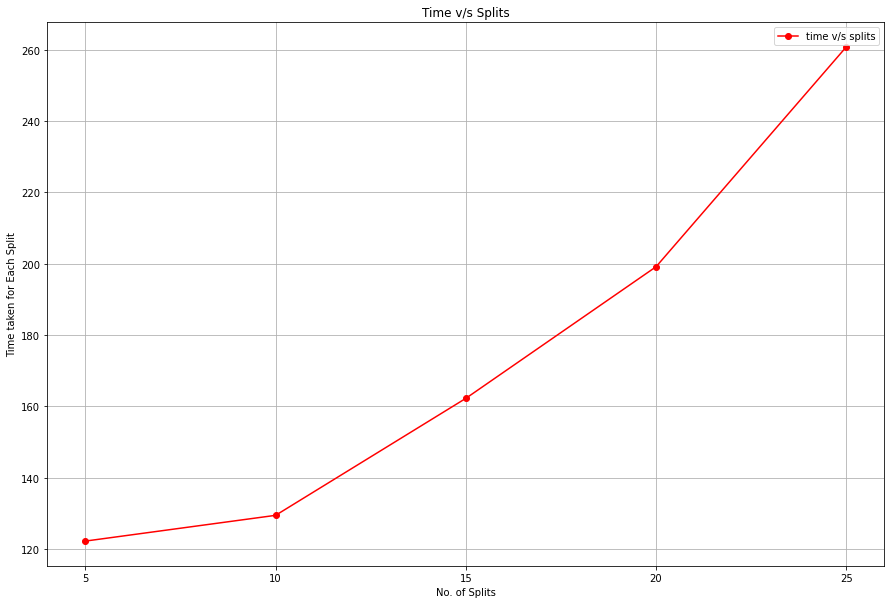

In [10]:
plt.figure(figsize = (15, 10))
plt.plot(n_splits_list, time_taken_list, color = 'r', label = "time v/s splits", marker = "o")
plt.xlabel("No. of Splits")
plt.xticks([k for k in n_splits_list], n_splits_list)
plt.ylabel("Time taken for Each Split")
plt.legend(loc = 'best')
plt.title("Time v/s Splits")
plt.grid(); plt.show()

In [12]:
globalSup = 500
best_n_splits = 5
support = [int(globalSup/best_n_splits) for _ in range(best_n_splits)]
params = {"support": support, "globalSup":globalSup , "size_of_transaction": len(data), "time_calc": True}
partition_instance = Partition(**params)
partitioned_data = partition_instance.split(data, best_n_splits, random_state = 23)
_, time_list = partition_instance.fit(partitioned_data)

No. of possible candidates:  289


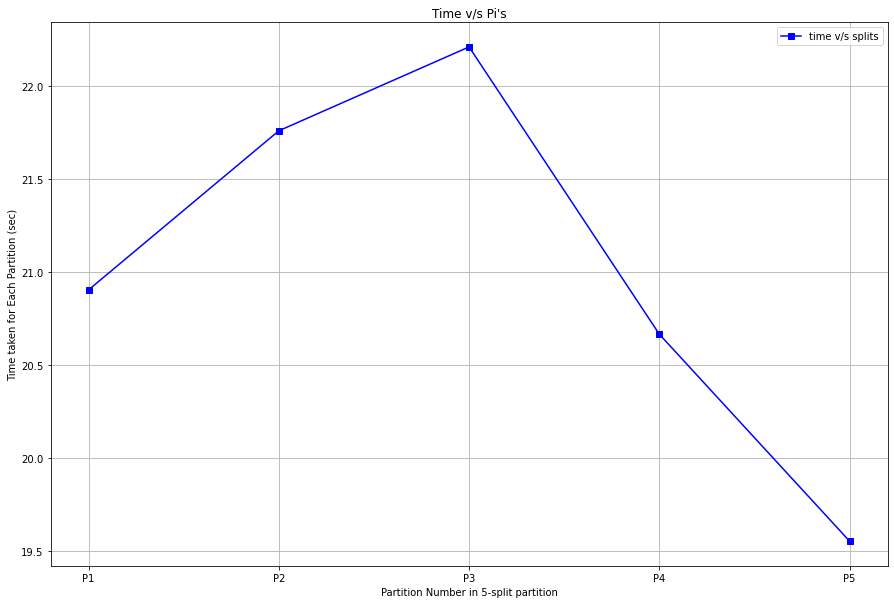

In [14]:
plt.figure(figsize = (15, 10))
plt.plot([k for k in range(1, best_n_splits+1)], time_list, color = 'b', label = "time v/s splits", marker = "s")
plt.xlabel("Partition Number in 5-split partition")
plt.xticks([k for k in range(1, best_n_splits+1)], ["P"+str(k) for k in range(1, best_n_splits+1)])
plt.ylabel("Time taken for Each Partition (sec)")
plt.legend(loc = 'best')
plt.title("Time v/s Pi's")
plt.grid(); plt.show()

## Hash-Tree Based Implementation

In [4]:
def find_frequent_one(data_set, support):
    """
    Find frequent one itemsets within data set
    :param data_set:
    :param support: Provided support value
    """
    candidate_one = {}
    total = len(data_set)
    for row in data_set:
        for val in row:
            if val in candidate_one:
                candidate_one[val] += 1
            else:
                candidate_one[val] = 1

    frequent_1 = []
    for key, cnt in candidate_one.items():
        # check if given item has sufficient count.
        if cnt >= (support * total / 100):
            frequent_1.append(([key], cnt))
    return frequent_1


class HNode:
    """
    Class which represents node in a hash tree.
    """

    def __init__(self):
        self.children = {}
        self.isLeaf = True
        self.bucket = {}


class HTree:
    """
    Wrapper class for HTree instance
    """

    def __init__(self, max_leaf_cnt, max_child_cnt):
        self.root = HNode()
        self.max_leaf_cnt = max_leaf_cnt
        self.max_child_cnt = max_child_cnt
        self.frequent_itemsets = []

    def recur_insert(self, node, itemset, index, cnt):
        # TO-DO
        """
        Recursively adds nodes inside the tree and if required splits leaf node and
        redistributes itemsets among child converting itself into intermediate node.
        node:
        itemset:
        index:
        """
        if index == len(itemset):
            # last bucket so just insert
            if itemset in node.bucket:
                node.bucket[itemset] += cnt
            else:
                node.bucket[itemset] = cnt
            return

        if node.isLeaf:
            
            if itemset in node.bucket:
                node.bucket[itemset] += cnt
            else:
                node.bucket[itemset] = cnt
            if len(node.bucket) == self.max_leaf_cnt:
                # bucket has reached its maximum capacity and its intermediate node so
                # split and redistribute entries.
                for old_itemset, old_cnt in node.bucket.items():
                    
                    hash_key = self._hash(old_itemset[index])
                    if hash_key not in node.children:
                        node.children[hash_key] = HNode()
                    self.recur_insert(node.children[hash_key], old_itemset, index + 1, old_cnt)
                # there is no point in having this node's bucket
                # so just delete it
                del node.bucket
                node.isLeaf = False
        else:
            hash_key = self._hash(itemset[index])
            if hash_key not in node.children:
                node.children[hash_key] = HNode()
            self.recur_insert(node.children[hash_key], itemset, index + 1, cnt)

    def insert(self, itemset):
        # as list can't be hashed we need to convert this into tuple
        # which can be easily hashed in leaf node buckets
        itemset = tuple(itemset)
        self.recur_insert(self.root, itemset, 0, 0)

    def add_support(self, itemset):
        """Add support count for itemSet in each Transaction..."""
        runner = self.root
        itemset = tuple(itemset)
        index = 0
        while True:
            if runner.isLeaf:
                if itemset in runner.bucket:
                    runner.bucket[itemset] += 1
                break
            hash_key = self._hash(itemset[index])
            if hash_key in runner.children:
                runner = runner.children[hash_key]
            else:
                break
            index += 1

    def dfs(self, node, support_cnt):
        if node.isLeaf:
            for key, value in node.bucket.items():
                if value >= support_cnt:
                    self.frequent_itemsets.append((list(key), value))
                    # print key, value, support_cnt
            return

        for child in node.children.values():
            self.dfs(child, support_cnt)

    def get_frequent_itemsets(self, support_cnt):
        """
        Returns all frequent itemsets which can be considered for next level
        :param support_cnt: Minimum cnt required for itemset to be considered as frequent
        :return:
        """
        self.frequent_itemsets = []
        self.dfs(self.root, support_cnt)
        return self.frequent_itemsets

    def _hash(self, val):
        return val % self.max_child_cnt


def generate_hash_tree(candidate_itemsets, length, max_leaf_cnt = 10, max_child_cnt = 11):
    """
    This function generates hash tree of itemsets with each node having no more than child_max_length
    childs and each leaf node having no more than max_leaf_length.
    :param candidate_itemsets: Itemsets
    :param length: Length if each itemset
    :param max_leaf_length:
    :param child_max_length:
    """
    htree = HTree(max_child_cnt, max_leaf_cnt)
    for itemset in candidate_itemsets:
        # add this itemset to hashtree
        htree.insert(itemset)
    return htree


def generate_k_subsets(dataset, length):
    subsets = []
    for itemset in dataset:
        subsets.extend(map(list, itertools.combinations(itemset, length)))
    return subsets


def is_prefix(list_1, list_2):
    for i in range(len(list_1) - 1):
        if list_1[i] != list_2[i]:
            return False
    return True


def apriori_generate_frequent_itemsets(dataset, support):
    """
    Generates frequent itemsets
    :param dataset:
    :param support:
    :return: List of f-itemsets with their respective count in
            form of list of tuples.
    """
    support_cnt = int(support / 100.0 * len(dataset))
    all_frequent_itemsets = find_frequent_one(dataset, support)
    prev_frequent = [x[0] for x in all_frequent_itemsets]
    length = 2
    while len(prev_frequent) > 1:
        new_candidates = []
        for i in range(len(prev_frequent)):
            j = i + 1
            while j < len(prev_frequent) and is_prefix(prev_frequent[i], prev_frequent[j]):
                # this part makes sure that all of the items remain lexicographically sorted.
                new_candidates.append(prev_frequent[i][:-1] +
                                      [prev_frequent[i][-1]] +
                                      [prev_frequent[j][-1]])
                j += 1

        # generate hash tree and find frequent itemsets
        h_tree = generate_hash_tree(new_candidates, length)
        # for each transaction, find all possible subsets of size "length"
        k_subsets = generate_k_subsets(dataset, length)

        # support counting and finding frequent itemsets
        for subset in k_subsets:
            h_tree.add_support(subset)

        # find frequent itemsets
        new_frequent = h_tree.get_frequent_itemsets(support_cnt)
        all_frequent_itemsets.extend(new_frequent)
        prev_frequent = [tup[0] for tup in new_frequent]
        prev_frequent.sort()
        length += 1

    return all_frequent_itemsets

## Comparison TIME :)

In [11]:
SUPPORT_List = [550, 650, 750, 850, 950]

In [12]:
ap_time, ht_time, part_time = [], [], []
best_n_splits = 5

for minSup in SUPPORT_List:
    
    apriori = Apriori(minSup/len(data), ["itemsets", "support"], probs_true = False)
    # For Apriori 
    start_ap = timeit.default_timer()
    _ = apriori.fit(data)
    stop_ap = timeit.default_timer()
    # For Apriori -- Append the Time
    ap_time.append(stop_ap - start_ap)
    # For HT Tree...
    start_ht = timeit.default_timer()
    _ = apriori_generate_frequent_itemsets(data, (minSup*100)/len(data))
    stop_ht = timeit.default_timer()
    # for ht_time append...
    ht_time.append(stop_ht - start_ht)
    # For Partition based...
    support = [int(minSup/best_n_splits) for _ in range(best_n_splits)]
    params = {"support": support, "globalSup":minSup , "size_of_transaction": len(data)}
    partition_instance = Partition(**params)
    partitioned_data = partition_instance.split(data, best_n_splits, random_state = 23)
    start_part = timeit.default_timer()
    _ = partition_instance.fit(partitioned_data)
    stop_part = timeit.default_timer()
    part_time.append(stop_part - start_part)

No. of possible candidates:  234
No. of possible candidates:  165
No. of possible candidates:  114
No. of possible candidates:  84
No. of possible candidates:  63


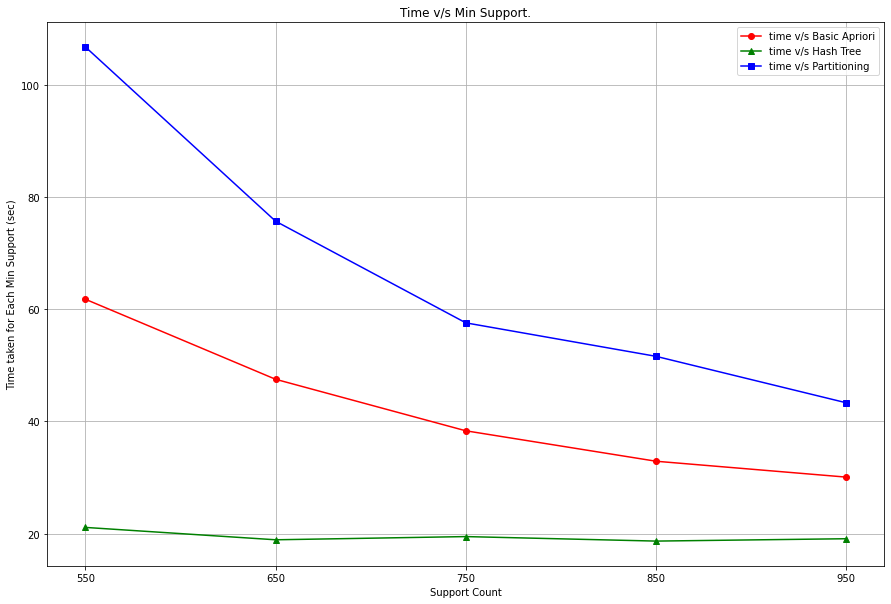

In [15]:
# Plot the Results...
plt.figure(figsize = (15, 10))
plt.plot(SUPPORT_List, ap_time, color = 'r', label = "time v/s Basic Apriori", marker = "o")
plt.plot(SUPPORT_List, ht_time, color = 'g', label = "time v/s Hash Tree", marker = "^")
plt.plot(SUPPORT_List, part_time, color = 'b', label = "time v/s Partitioning", marker = "s")
plt.xlabel("Support Count")
plt.xticks([k for k in SUPPORT_List], SUPPORT_List)
plt.ylabel("Time taken for Each Min Support (sec)")
plt.legend(loc = 'best')
plt.title("Time v/s Min Support.")
plt.grid(); plt.show()